# Исследование закономерностей, определяющих популярность игр

Из открытых источников нам доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Представлены данные до 2016 года.
    
Наш план действий такой:
   
1. Посмотрим на данные, уберем дубликаты, изменим тип и избавимся от пропусков
    
2. Посмотрим как менялись продажи игр по годам и платформам и определим актуальный период и топ платформ
    
3. Посмотрим, как зависят продажи от рейтинга критиков и пользователей

4. Нарисуем портрет пользователя из 3 регионов - Северно Америки, Европы и Японии
    
5. Проверим две гипотезы на равенство пользовательских рейтингов 

По итогу исследования мы узнаем, что и как влияет на продажи игр, чтобы опрелить закономерности успеха
    
Name — название игры

Platform — платформа

Year_of_Release — год выпуска

Genre — жанр игры

NA_sales — продажи в Северной Америке (миллионы проданных копий)

EU_sales — продажи в Европе (миллионы проданных копий)

JP_sales — продажи в Японии (миллионы проданных копий)

Other_sales — продажи в других странах (миллионы проданных копий)

Critic_Score — оценка критиков (максимум 100)

User_Score — оценка пользователей (максимум 10)

Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats as st
plt.rcParams.update({'figure.max_open_warning': 0})

### Шаг 1. Открываем файл с данными и изучаем общую информацию

In [2]:
pth1 = 'games.csv'
pth2 = '/datasets/games.csv'

if os.path.exists(pth1):
    games = pd.read_csv(pth1)
elif os.path.exists(pth2):
    games = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В наших данных 16715 строк, пропусков больше всего в колонке с рейтингом критиков и возрастном рейтинге. Есть 2 строчки без названия игры и жанра. В некоторых придется поменять тип данных, изменить регистр.

### Шаг 2. Подготавливаем данные

In [5]:
new_columns = [column.lower() for column in games.columns]
games.columns = new_columns

In [6]:
games['year_of_release'] = pd.to_numeric(games['year_of_release'], downcast='integer')
games['critic_score'] = pd.to_numeric(games['critic_score'], downcast='integer')
games['user_score'] = games['user_score'].replace('tbd', np.nan, regex=True)
games['user_score'] = games['user_score'].astype(float)
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


Меняем тип данных, чтобы было удобнее работать. Год - явно целое число, в рейтинге критиков по факту целые числа с точкой, а рейтинге пользователей - дробные.  "tbd" означает, что сейчас идет оценивание и оценки нет, поэтому все "tbd" можно заменить на NaN.


In [7]:
games.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Попробуем восстановить данные. Есть пропуски в имени и жанре - их придется удалить.

In [8]:
games[games['genre'].isna()]
games[games['name'].isna()]
games.drop([659, 14244],inplace=True)

In [9]:
games_year_nan = games[games['year_of_release'].isna()]
games_year_nan

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,NaN,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [10]:
games_year_nan['genre'].value_counts()

Action          62
Sports          42
Misc            29
Shooter         27
Racing          23
Role-Playing    17
Simulation      16
Fighting        12
Puzzle          11
Platform        10
Adventure       10
Strategy        10
Name: genre, dtype: int64

In [11]:
games['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Всего 16715 строк, 269 - это чуть больше 1%, потерять столько не страшно. В некоторых играх год есть в названии. 
В целом все отсутсвующие значения по году это не больше 2% в потере жанров. Критичный уровень потерь записей на этапе предобработки составляет 10%, оптимальный 5%

Пропуски в данных могут быть как простой потерей, например те строки без имени, так и отсутвующими данными, например, рейтинг. Некототрые игры просто не успели получить оценку.

In [12]:
games.drop(games[games['year_of_release'].isna()].index,inplace=True)
games['year_of_release'] = pd.to_numeric(games['year_of_release'], downcast='integer')
games.drop_duplicates(subset=None, keep='first', inplace=False, ignore_index=False)
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   float64
 10  rating           9768 non-null   object 
dtypes: float64(6), int16(1), object(4)
memory usage: 1.4+ MB


В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков». Выпущен  1994 году, поэтому у некоторых игр его может и не быть.

#### Посчитаем суммарные продажи по регионам 

In [13]:
games['total_sales'] = games[['na_sales','eu_sales','jp_sales','other_sales']].sum(axis=1)

Итак, мы посмотрели данные, избавились от дубликатов, изменили тип на целочисленный и удалили лишнее - данные без названия и жанра.
Нам доступен датасет с 1644 строками и информацией об играх, платформах, на которых они выпускались, продажах в разных странах и ретингах. 
А так же добавили столбец с общей суммой продаж, на основании данных из которого и будем делать выводы о популряности.

### Шаг 3. Исследовательский анализ

#### Посмотрим данные по годам

<AxesSubplot:title={'center':'Разброс игр по годам'}, xlabel='Год выпуска', ylabel='Количество игр'>

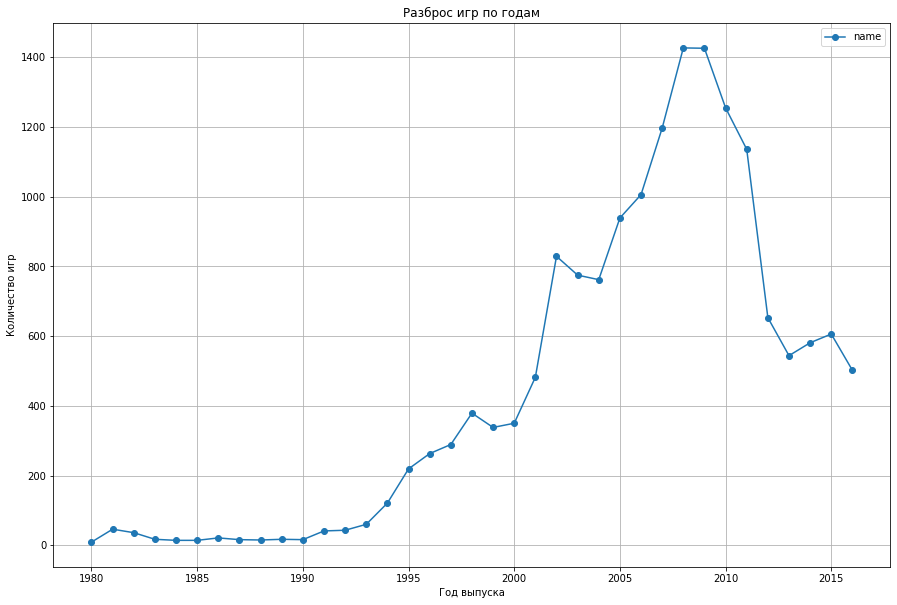

In [14]:
game_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count')
game_year.plot(title='Разброс игр по годам', xlabel = 'Год выпуска', 
               ylabel = 'Количество игр', grid=True, style='o-', figsize=(15, 10))

Можно заметить, как количество игр начало расти после 2000, но стоит учитывать и тот момент, что количество игр в данных может быть в неравных соотношениях по годам. Видим резкий скачок к 2008, спад в 2013, затем снова рост

Если мы вообще представим, что сейчас декабрь 2016, а мы планируем кампанию на 2017, то данные как минимум до 2005, а то и до 2010 вообще не нужны.

#### Посмотрим данные по платформам

Text(0, 0.5, 'Количество игр')

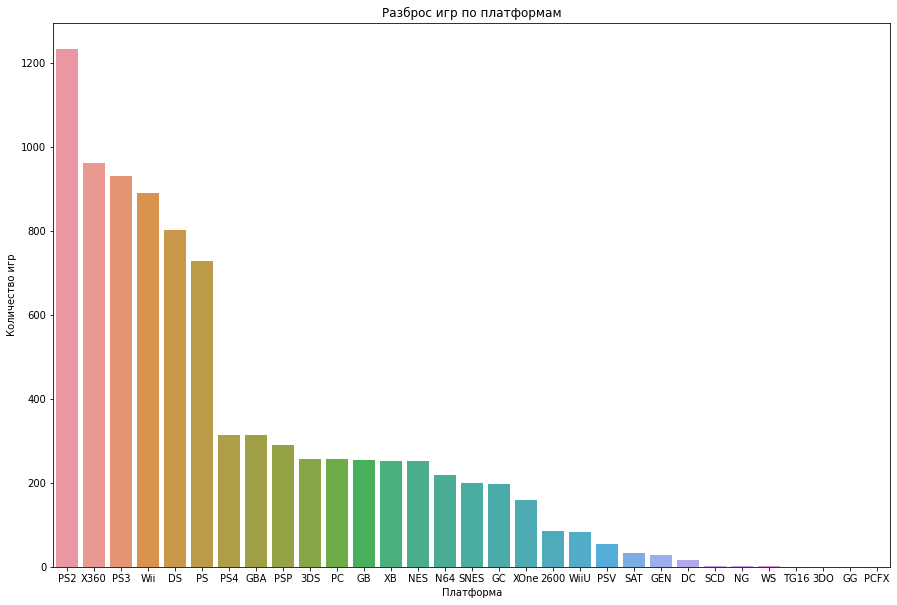

In [15]:
games_sale_platform = games.pivot_table(index='platform', values='total_sales',
                                        aggfunc='sum').sort_values(by='total_sales', ascending=False)
plt.figure(figsize=(15,10))
sns.barplot(x=games_sale_platform.index,y=games_sale_platform['total_sales']) 
plt.title("Разброс игр по платформам")
plt.xlabel("Платформа")
plt.ylabel("Количество игр")

Становится сразу видно, что топ-6 самых популярных - PS 1-3, Xbox360, Wii и Nintendo DS. Это как раз можно объяснить годами выпуска игр. Но опять же важно понимать сколько игр выпускалось по годам, так как некоторые из них могут быть совсем старыми, а другие - наоборот, совсем новыми

In [16]:
games_sale_platform = games_sale_platform.reset_index()
platform_top = games_sale_platform['platform'].unique()
platform_top

array(['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP',
       '3DS', 'PC', 'GB', 'XB', 'NES', 'N64', 'SNES', 'GC', 'XOne',
       '2600', 'WiiU', 'PSV', 'SAT', 'GEN', 'DC', 'SCD', 'NG', 'WS',
       'TG16', '3DO', 'GG', 'PCFX'], dtype=object)

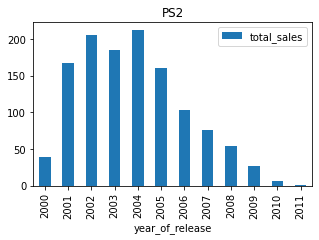

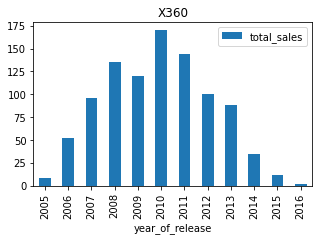

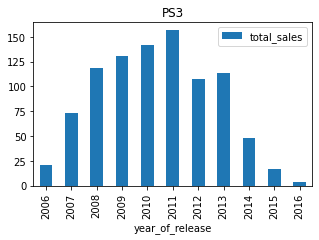

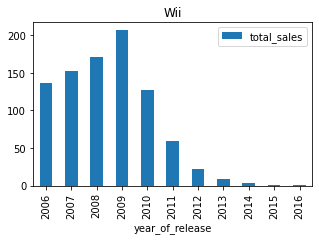

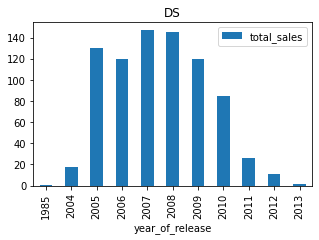

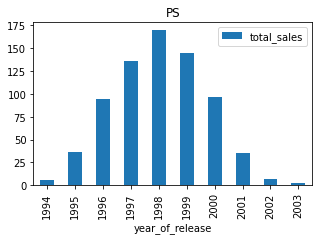

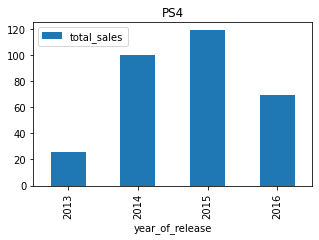

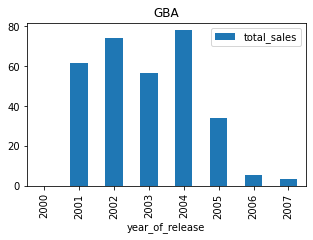

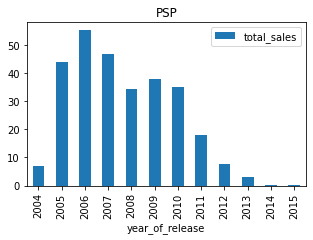

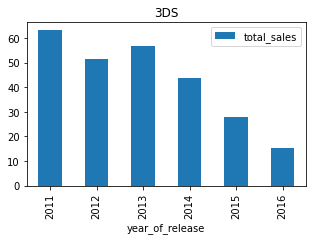

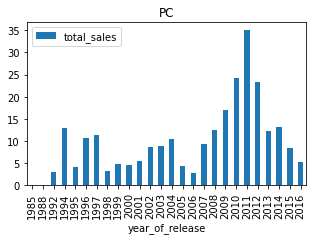

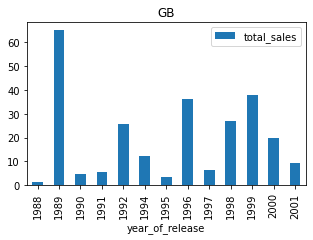

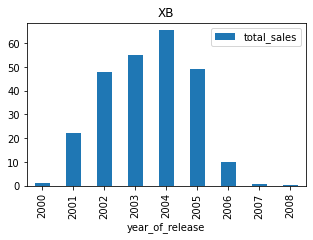

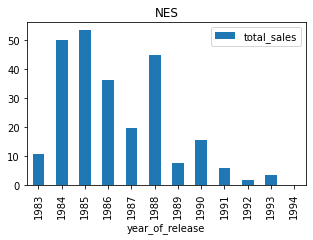

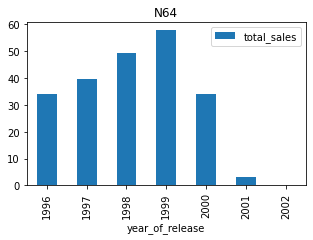

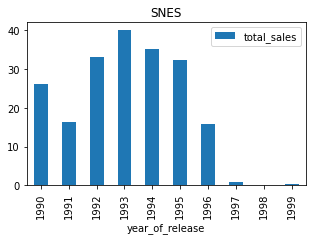

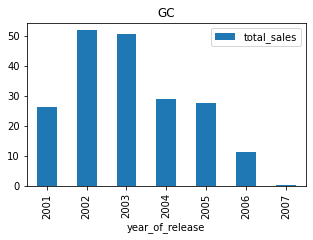

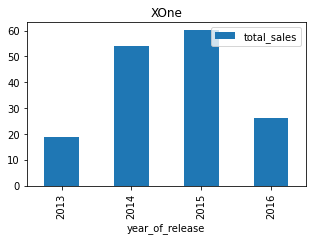

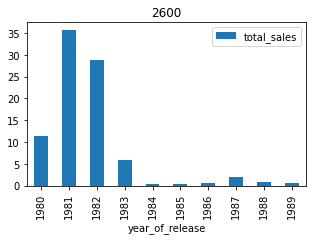

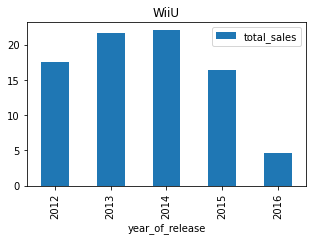

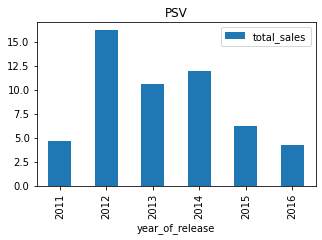

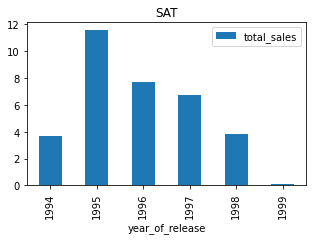

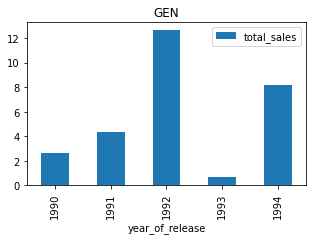

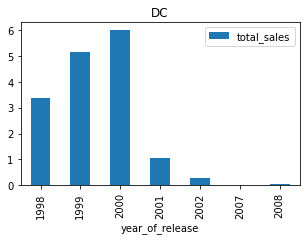

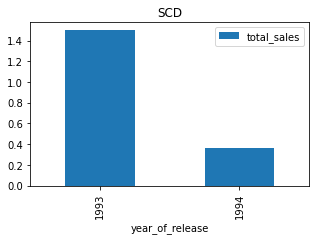

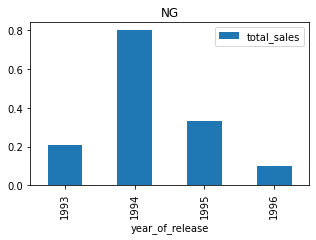

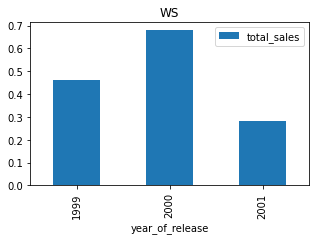

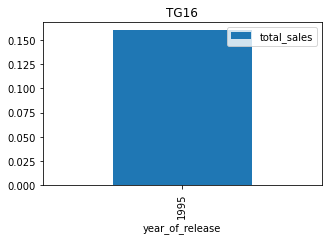

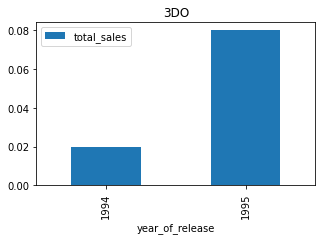

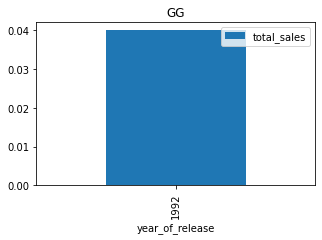

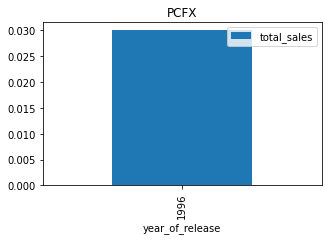

In [17]:
for platform in platform_top:
    games[games['platform'] == platform].pivot_table(index='year_of_release',
                                                     values='total_sales', aggfunc='sum').plot(
        kind='bar', figsize=(5,3))
    plt.title(platform)

Сразу становится видно, что есть платформы, на которых, согласно нашим данным, игр с 2002 нет вообще (у некоторых и раньше) У Xb, например, игры есть, но с 2002 резко упали и почти сравнялись с 0. Стоит определить платформы для исследования самостоятельно, так как некоторые к 2016 совсем теряют популярность, тогда использовать данные по ним будет бессмысленно. Так же в данных есть платформы нескольких поколений. Возможно есть смысл взять последние поколения, учитывая средний срок жизни платформ.

In [18]:
top = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(
    by='total_sales', ascending=False).reset_index().rename_axis(None, axis=1)


In [19]:
top

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


Судя по всему, средний срок жизни платформ ~10 лет, у каких то есть и меньше (но может дело в наших данных). Топ 6 это PS2, X360, PS3, WII, DS и PS.
На 2016 остается не так много платформ, большая часть уже неактуальна, ее заменяют новые и это нормально. В целом к 2016 они все уже не так актуальны, но мы знаем, что данные за 2016 неполные.
Возьмем для исследования данные после 2009, до - слишко далеко от 2017, а после как раз начались изменения, не только просто рост, что в целом говорит о нарастающей популярности таких игр.

#### Определяем данные за нужные года и идем дальше

In [20]:
games_sort = games[games['year_of_release'] > 2013]
games_sort

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NaN,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NaN,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NaN,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [22]:
top6_list = ['PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU']
top6plat = games_sort[games_sort['platform'].isin(top6_list)]
top6plat = top6plat[top6plat['total_sales']<1.5]
top6plat #строки с топ 6 платформ

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1274,Batman: Arkham Knight,XOne,2015,Action,0.88,0.47,0.00,0.14,85.0,6.6,M,1.49
1275,Doom (2016),PS4,2016,Shooter,0.54,0.69,0.02,0.24,NaN,NaN,NaN,1.49
1314,Madden NFL 15,PS3,2014,Sports,1.08,0.11,0.00,0.27,NaN,2.7,E,1.46
1384,Tomb Raider (2013),PS4,2014,Action,0.47,0.65,0.06,0.22,NaN,NaN,NaN,1.40
1386,Forza Horizon 2,XOne,2014,Racing,0.50,0.78,0.01,0.11,86.0,8.2,E10+,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...
16672,Metal Gear Solid V: The Definitive Experience,XOne,2016,Action,0.01,0.00,0.00,0.00,NaN,NaN,M,0.01
16674,Tsukigime Ranko's Longest Day,PS3,2014,Action,0.00,0.01,0.00,0.00,NaN,NaN,NaN,0.01
16677,Aikatsu Stars! My Special Appeal,3DS,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01
16691,Dynasty Warriors: Eiketsuden,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN,0.01


In [23]:
top_sale = pd.pivot_table(top6plat, index='platform', 
                                     values='total_sales', aggfunc = 'sum').sort_values(
    'total_sales', ascending=False)
top_sale # топ 6 платформ с суммой продаж

,total_sales
platform,
PS4,83.93
XOne,62.80
PS3,46.53
3DS,35.96
X360,32.15
WiiU,20.26


#### Строим ящик с усами

In [24]:
top6plat.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,200.0,0.179800,0.248547,0.01,0.03,0.080,0.2100,1.38
PS3,212.0,0.219481,0.288101,0.01,0.03,0.100,0.2725,1.46
PS4,321.0,0.261464,0.310446,0.01,0.05,0.120,0.3600,1.49
WiiU,67.0,0.302388,0.336362,0.01,0.05,0.130,0.4700,1.30
X360,104.0,0.309135,0.338174,0.01,0.07,0.165,0.4350,1.36
XOne,203.0,0.309360,0.370887,0.01,0.04,0.150,0.4450,1.49


Тут мы видим среднюю сумму продаж по топ-6 платформам, минимальные продажи и макимальные, а так же какие продажи модем считать меньше "нормы" и больше - 25 и 75% соответственно

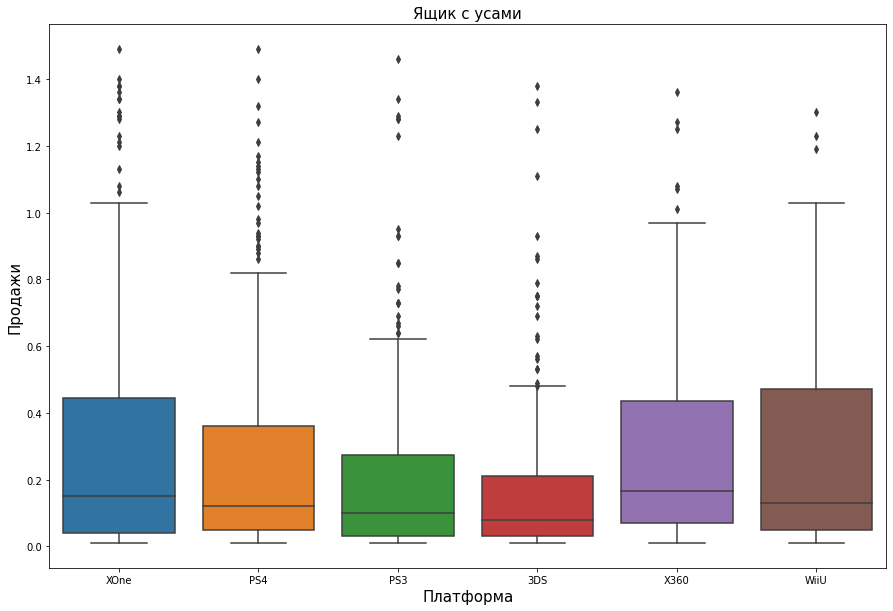

In [25]:
plt.figure(figsize=(15,10))
sns.boxplot(data=top6plat, x='platform', y='total_sales')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=15)
plt.ylabel('Продажи',fontsize=15);

Больше всего продаж у WiiU и XOne, затем x360 и PS4.

#### Продажи внутри одной платформы

In [26]:
wiiu = games_sort[games_sort['platform']=='WiiU']
wiiu['user_score'].corr(wiiu['total_sales'])

0.40792645792170773

In [27]:
wiiu = games_sort[games_sort['platform']=='WiiU']
wiiu['critic_score'].corr(wiiu['total_sales'])

0.370201412480884

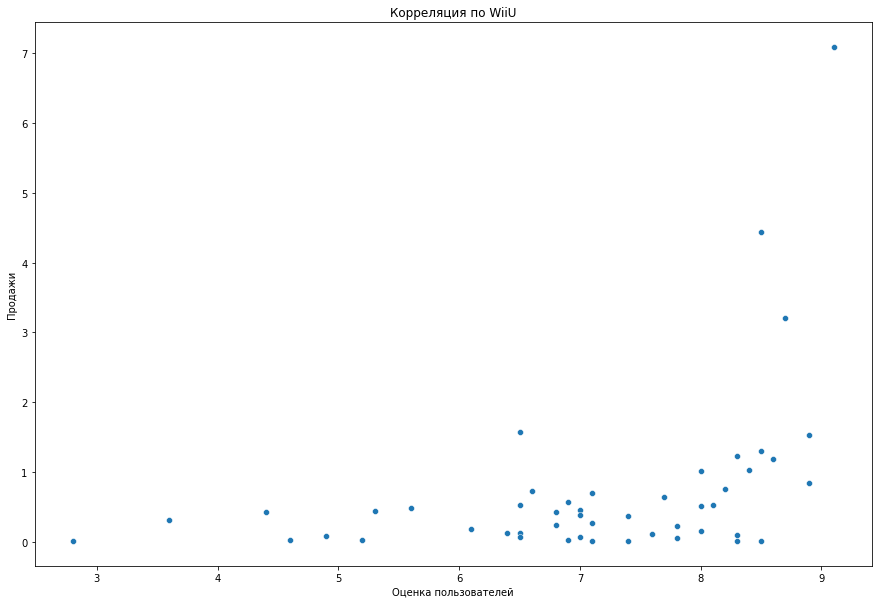

In [28]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='user_score', y='total_sales', data=wiiu)
plt.title('Корреляция по WiiU')
plt.xlabel('Оценка пользователей')
plt.ylabel('Продажи');

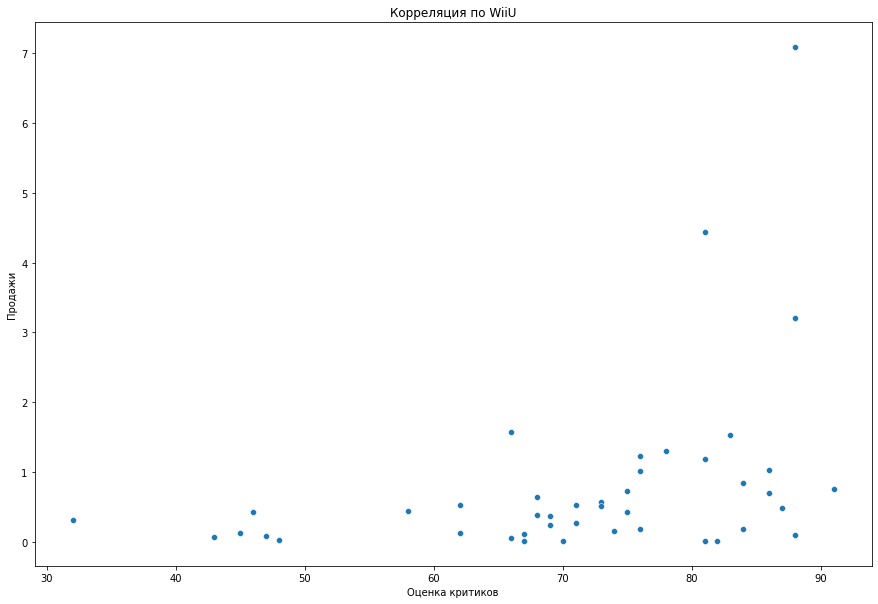

In [29]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='critic_score', y='total_sales', data=wiiu)
plt.title('Корреляция по WiiU')
plt.xlabel('Оценка критиков')
plt.ylabel('Продажи');

Продажи WiiU напрямую зависят от оценки игроков больше, чем от оценки критиков

In [30]:
xone = games_sort[games_sort['platform']=='XOne']
xone['user_score'].corr(xone['total_sales'])

-0.0703839280647581

корреляция между оценкой пользователей и продажами слабая обратная 

In [31]:
xone = games_sort[games_sort['platform']=='XOne']
xone['critic_score'].corr(xone['total_sales'])

0.42867694370333226

 корреляция между оценкой критиков и продажами умеренная

In [32]:
ds = games_sort[games_sort['platform']=='3DS']
ds['user_score'].corr(ds['total_sales'])

0.2151932718527028

 корреляция между оценкой пользователей и продажами умеренная

In [33]:
ds = games_sort[games_sort['platform']=='3DS']
ds['critic_score'].corr(ds['total_sales'])

0.314117492869051

 корреляция между оценкой критиков и продажами умеренная

In [34]:
ps4 = games_sort[games_sort['platform']=='PS4']
ps4['user_score'].corr(ps4['total_sales'])

-0.040131589472697356

 корреляция между оценкой пользователей и продажами слабая обратная

In [35]:
ps4 = games_sort[games_sort['platform']=='PS4']
ps4['critic_score'].corr(ps4['total_sales'])

0.40266141068104083

 корреляция между оценкой критиков и продажами умеренная

In [36]:
ps3 = games_sort[games_sort['platform']=='PS3']
ps3['user_score'].corr(ps3['total_sales'])

-0.16676141347662118

 корреляция между оценкой пользователей и продажами слабая обратная

In [37]:
ps3 = games_sort[games_sort['platform']=='PS3']
ps3['critic_score'].corr(ps3['total_sales'])

0.44657460493190704

 корреляция между оценкой критиков и продажами умеренная

In [38]:
x360 = games_sort[games_sort['platform']=='X360']
x360['user_score'].corr(x360['total_sales'])

-0.138444570945665

 корреляция между оценкой пользователей и продажами слабая обратная

In [39]:
x360 = games_sort[games_sort['platform']=='X360']
x360['critic_score'].corr(x360['total_sales'])

0.5257228356581523

 корреляция между оценкой критиков и продажами умеренная

В целом вывод такой, что продажи зависят больше от оценки критиков, только у wiiu оценка пользователей значит больше, чем оценка критиков.

#### Самые популярные жанры

In [40]:

top_genre = pd.pivot_table(games_sort, index='genre', values='total_sales',
                           aggfunc = 'median').sort_values('total_sales', ascending=False
                                                       ).reset_index().rename_axis(None, axis=1)
top_genre

,genre,total_sales
0,Shooter,0.515
1,Sports,0.180
2,Platform,0.140
3,Fighting,0.125
4,Role-Playing,0.110
5,Simulation,0.100
6,Action,0.090
7,Misc,0.090
8,Racing,0.090
9,Strategy,0.060


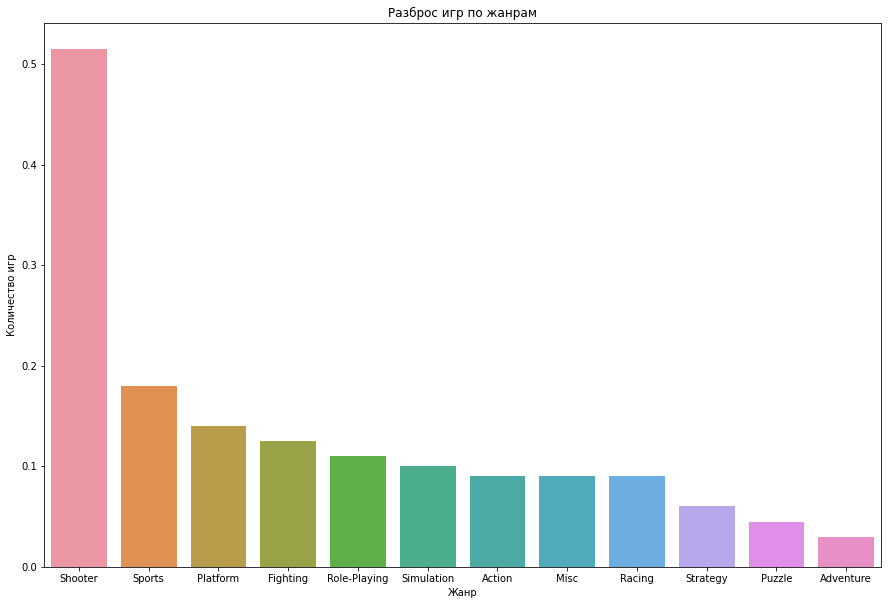

In [41]:
plt.figure(figsize=(15,10))
sns.barplot(data=top_genre, x='genre', y='total_sales') 
plt.title("Разброс игр по жанрам")
plt.xlabel("Жанр")
plt.ylabel("Количество игр");

Самые популярные жанры - это shooter, sports, platform, fighting и role-playing. Самый продаваемый - shooter, самый непопулярный - adventure.

### Шаг 4. Портрет пользователя каждого региона.

#### Пользователь NA

In [42]:
na_plat = pd.pivot_table(games_sort, index='platform', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)
na_plat

,na_sales
platform,
PS4,98.61
XOne,81.27
X360,28.30
3DS,22.64
PS3,22.05
WiiU,19.36
PC,7.23
PSV,2.52
Wii,2.08


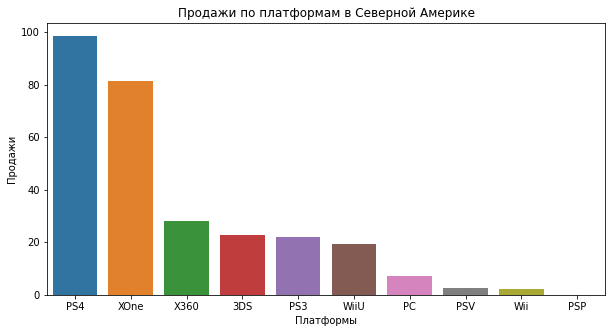

In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data=na_plat, x=na_plat.index, y='na_sales') 
plt.title("Продажи по платформам в Северной Америке")
plt.xlabel("Платформы")
plt.ylabel("Продажи");

In [44]:
na_genre = pd.pivot_table(games_sort, index='genre', values='na_sales',
                                        aggfunc='sum').sort_values('na_sales', ascending=False)
na_genre

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05
Fighting,12.43
Racing,8.74
Platform,6.79
Adventure,5.64


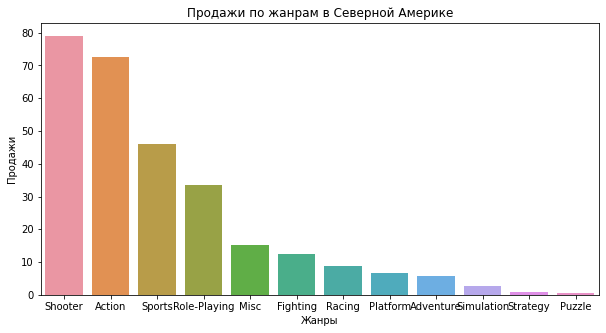

In [45]:
plt.figure(figsize=(10,5))
sns.barplot(data=na_genre, x=na_genre.index, y='na_sales') 
plt.title("Продажи по жанрам в Северной Америке")
plt.xlabel("Жанры")
plt.ylabel("Продажи");

In [46]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [47]:
games_sort['rating'].unique()

array([nan, 'M', 'E', 'T', 'E10+'], dtype=object)

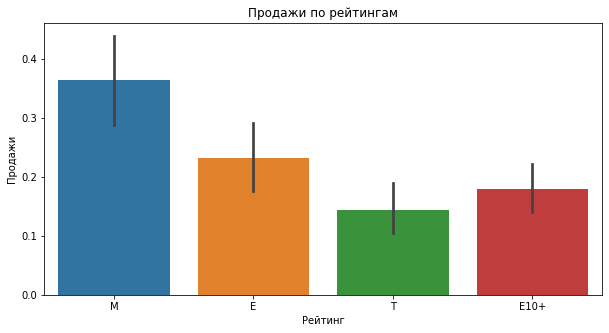

In [48]:
plt.figure(figsize=(10,5))
sns.barplot(data=games_sort, x='rating', y='na_sales') 
plt.title("Продажи по рейтингам")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи");

Пользователь Северной Америки предпочитает PS4, XOne, X360, 3DS, PS3, из жарнов - это шутер, экшн и спорт, ролевики и микс. 

По рейтингу преобладют игры 17+ и все возраста, чуть меньше для лиц 10+ и еще меньше 13+


#### Пользователь EU

In [49]:
eu_plat = pd.pivot_table(games_sort, index='platform', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_plat

,eu_sales
platform,
PS4,130.04
XOne,46.25
PS3,25.54
PC,17.97
3DS,16.12
X360,15.49
WiiU,13.15
PSV,3.53
Wii,2.59


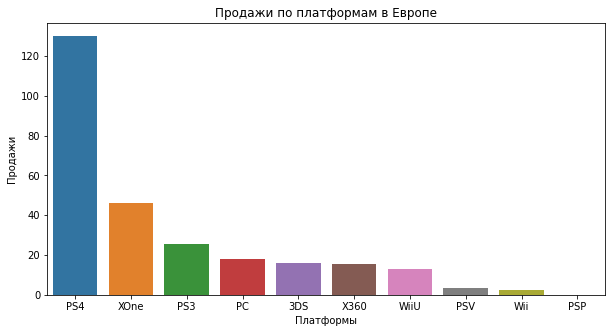

In [50]:
plt.figure(figsize=(10,5))
sns.barplot(data=eu_plat, x=eu_plat.index, y='eu_sales') 
plt.title("Продажи по платформам в Европе")
plt.xlabel("Платформы")
plt.ylabel("Продажи");

In [51]:
eu_genre = pd.pivot_table(games_sort, index='genre', values='eu_sales',
                                        aggfunc='sum').sort_values('eu_sales', ascending=False)
eu_genre

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13
Misc,12.86
Simulation,7.30
Platform,6.80
Fighting,6.69


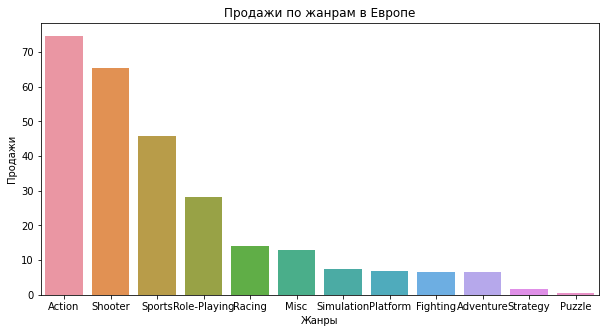

In [52]:
plt.figure(figsize=(10,5))
sns.barplot(data=eu_genre, x=eu_genre.index, y='eu_sales') 
plt.title("Продажи по жанрам в Европе")
plt.xlabel("Жанры")
plt.ylabel("Продажи");

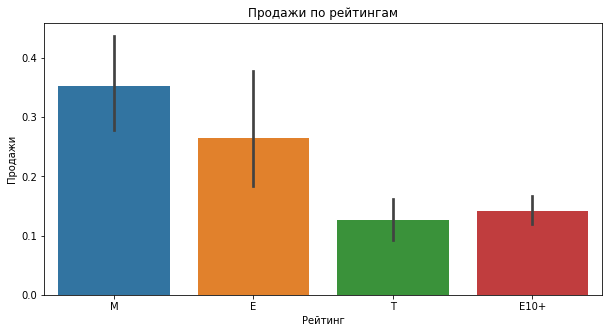

In [53]:
plt.figure(figsize=(10,5))
sns.barplot(data=games_sort, x='rating', y='eu_sales') 
plt.title("Продажи по рейтингам")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи");

Типичный пользователь из Европы предпочитает PS4, XOne, PS3, PC, 3DS, среди жанров выделяются Action, Shooter и Sports, Role-Playing и Racing.

По рейтингу ольше всего продаж игр 17+, все возраста, затем 10+ и 13+

#### Пользователь JP

In [54]:
jp_plat = pd.pivot_table(games_sort, index='platform', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_plat

,jp_sales
platform,
3DS,44.24
PS4,15.02
PSV,14.54
PS3,11.22
WiiU,7.31
PSP,0.36
XOne,0.32
X360,0.08
PC,0.00


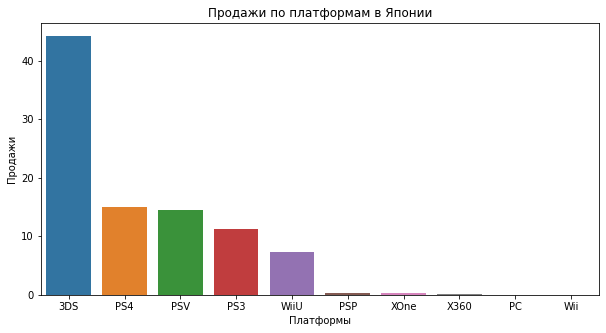

In [55]:
plt.figure(figsize=(10,5))
sns.barplot(data=jp_plat, x=jp_plat.index, y='jp_sales') 
plt.title("Продажи по платформам в Японии")
plt.xlabel("Платформы")
plt.ylabel("Продажи");

In [56]:
jp_genre = pd.pivot_table(games_sort, index='genre', values='jp_sales',
                                        aggfunc='sum').sort_values('jp_sales', ascending=False)
jp_genre

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87
Adventure,3.60
Sports,3.26
Platform,2.69
Simulation,2.31


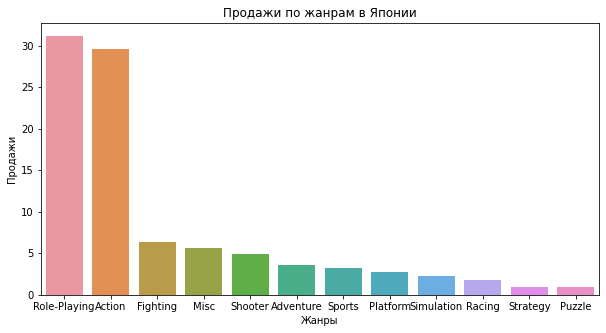

In [57]:
plt.figure(figsize=(10,5))
sns.barplot(data=jp_genre, x=jp_genre.index, y='jp_sales') 
plt.title("Продажи по жанрам в Японии")
plt.xlabel("Жанры")
plt.ylabel("Продажи");

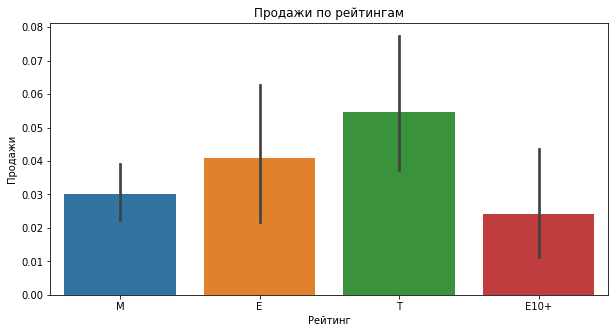

In [58]:
plt.figure(figsize=(10,5))
sns.barplot(data=games_sort, x='rating', y='jp_sales') 
plt.title("Продажи по рейтингам")
plt.xlabel("Рейтинг")
plt.ylabel("Продажи");

Типичный пользователь Японии это игрок на 3DS, PS4, PSV, PS3, WiiU. Из жарнов предпочитает Role-Playing, Action, Fighting, Misc и Shooter

По возрасту больше всего продаж для игроков от 13 лет, затем для всех возрастов, 17+ и чуть меньше 10+

Продаж без возрастного рейтинга не так уж и много по всем регионам

### Шаг 5. Проверка гипотез

####  Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Н0: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Н1: Средние пользовательские рейтинги платформ Xbox One и PC разные

In [59]:
xone_h = games_sort[(games_sort['platform']=='XOne')]['user_score'].dropna()
pc_h = games_sort[(games_sort['platform']=='PC')]['user_score'].dropna()

In [60]:
print(np.var(games_sort[games_sort['platform']=='XOne']['user_score']))
print(np.var(games_sort[games_sort['platform']=='PC']['user_score']))


1.879546005509642
2.8773743617307175


In [61]:
alpha = .01
results = st.ttest_ind(xone_h, pc_h, equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.11601398086668832
Не получилось отвергнуть нулевую гипотезу


Cредние рейтинги платформ  XOne и PC не имеют статистически значимых отличий 

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Н0: Средние пользовательские рейтинги жанров Action и Sports одинаковые

Н1: Средние пользовательские рейтинги жанров Action и Sports разные

In [62]:
action_h = games_sort[(games_sort['genre']=='Action')]['user_score'].dropna()
sports_h = games_sort[(games_sort['genre']=='Sports')]['user_score'].dropna()

In [63]:
print(np.var(games_sort[games_sort['genre']=='Action']['user_score']))
print(np.var(games_sort[games_sort['genre']=='Sports']['user_score']))


1.89208448117539
3.419837559675119


In [64]:
alpha = .01
results = st.ttest_ind(action_h, sports_h, equal_var=False)
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


Средние пользовательские рейтинги платформ Xbox One и PC не имеют статистически значимых различий, поэтому гипотезу об их сходстве отвергнуть не получилось, средние пользовательские рейтинги жанров Action  и Sports имеют статистически значимые различия, гипотезу об их равенстве отвергаем.
Нам важно узнать одинковые рейтинги или разные, поэтому применяем метод для проверки равенства средних у двух совокупностей. 

### Шаг 6. Общий вывод

1) Мы проанализировали данные из магазина "Стримчик" за несколько лет для того, чтобы определить закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании

2) Данные оканчиваются 2016 годом, причем за 2016 они неполные, для исследования были выбраны актуальные данные, которые мы ограничили 2009 годом. Средняя длительность жизни платформы 10 лет, но судя по нашим данным и графику узнали, что к 2008 году наблюдался активный рост популярности игр в целом, но с 2009 года пошел спад, затем снова небольшой рост, именно поэтому не стали брать данные за последние 10 лет. К тому же, если платформа наращивала популярность в этот промежуток времени, то к 2017 она бы "умерла" Данные ограничили 3 годами до 2017.

Проанализировав данные устранили аномалии и бесполезные строки, например, без названия игры, изменили тип данных и удалили дубликаты.

3) Топ 6 это PS4, XOne, 3DS, PS3, X360, WiiU.
На 2016 остается не так много платформ, большая часть уже неактуальна, ее заменяют новые и это нормально. В целом к 2016 они все уже не так актуальны, но мы знаем, что данные за 2016 неполные. Больше всего продаж у WiiU и XOne , затем X360 и PS4.

4) Продажи игр зависят больше от оценки критиков, чем пользователей. Это логично, когда у игры высокий рейтинг оценщика, покупить ее уже не так рисковано. Только у wiiu оценка пользователей значит больше, чем оценка критиков. Сама платформа выделялась необычным контроллером Wii Remote — он одним из первых предложил аудитории взаимодействовать с игрой в том числе с помощью движения. Wii — одна из немногих платформ, которая будоражила и хардкорных фанатов Nintendo, и тех, кто до этого предпочитал проводить досуг не за играми.

5) Самые популярные жанры - это shooter, sports, platform, fighting и role-playing. Самый высокопродаваемый - shooter, самый непопулярный - adventure. Тут тоже логика простая, чем меньше активного взаимодействия, тем хуже для популярности.

6) Проанализировали данные по регионам и описали типичных пользователей:

    Пользователь Северной Америки предпочитает PS4, XOne, X360, 3DS, PS3, из жарнов - это шутер, экшн и спорт, ролевики и микс. 
    Типичный пользователь из Европы предпочитает PS4, XOne, PS3, PC, 3DS, среди жанров выделяются Action, Shooter и Sports, Role-Playing и Racing.
    Типичный пользователь Японии это игрок на 3DS, PS4, PSV, PS3, WiiU. Из жарнов предпочитает Role-Playing, Action, Fighting, Misc и Shooter    

7) Средние пользовательские рейтинги платформ Xbox One и PC не имеют статистически значимых различий, поэтому гипотезу об их сходстве отвергнуть не получилось, средние пользовательские рейтинги жанров Action  и Sports имеют статистически значимые различия, гипотезу об их равенстве отвергаем.

В общем можно сказать, что платформа живет до 10 лет с подъемом и падением, затем ее заменяет новая, пусть даже это следующее поколение. Но эти новые поколения почти сразу становятся популярны, так как игроки уже знакомы с создателем.  

Платформы PS4 и XOne популярны в Европе и Америке, но вот в Японии список возглавляет 3DS. И в целом топ-5 платформ там другой, кроме PS4 и PS3. Поэтому стоит учитывать, либо для какой аудитории делать игру, либо выбрать универсальную популярную платформу - PS4. Жарны во всех регионах похожи, их  объединяет количество взаимодействия игрока с самой игрой, с интерфейсом. Чем больше такой активности, тем популярнее будет игра.